In [ ]:
df.to_csv['IRIS_imbalanced', index=False)

# SMOTE

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/GitHub/BP24/IRIS.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


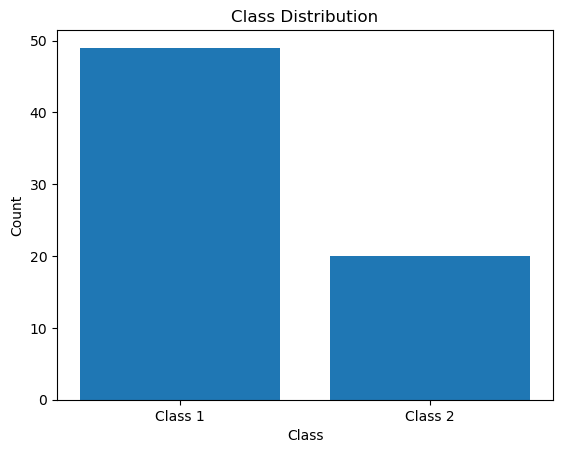

In [237]:
# Data exploration
x=df.drop(['species'],axis=1)[1:70] # 150 rows -> 70 rows to match with created imbalance
y=df['species'][1:70] # creating imbalance
count_class=df['species'][1:70].value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 1', 'Class 2'])
plt.show()
y.value_counts()

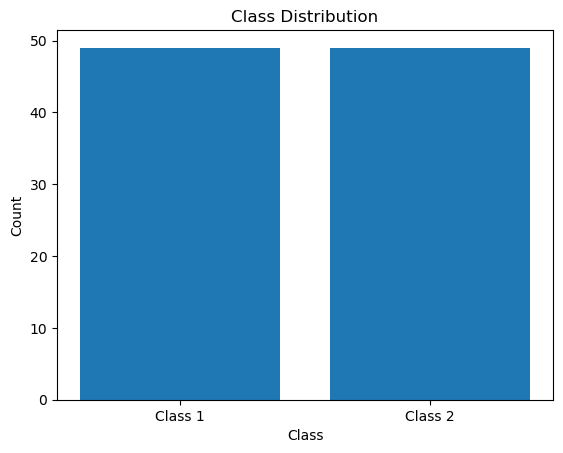

species
Iris-setosa        49
Iris-versicolor    49
Name: count, dtype: int64

In [147]:
# SMOTE to balance species classes
smote=SMOTE(sampling_strategy='minority')  # generating synthetic samples for minority class
x,y=smote.fit_resample(x,y) # re-sampling
y.value_counts() # Looking at counts post-SMOTE algoirthm

count_class=y.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 1', 'Class 2'])
plt.show()
y.value_counts()

# pmone & modpmone

In [149]:
import random
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def betterApplyAugmentationMethods(X_train, method, nrows, nvalues=None, unit=None, noise=None):
    # If nvalues not specified, entire column is selected
    if nvalues is None:
        nvalues = X_train.shape[1] - 1

    if str(method).lower() == 'pmone':
        # Creates empty dataframe to store augmented data
        augmentedDf = pd.DataFrame()

        # Randomly selects rows from data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Selects nvalues amount of unique column indexes
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Iterates through augmentedData and applies plus or minus to randCols indexes
        for i in range(augmentedDf.shape[0]):
            for col in randCols:
                if (random.randint(0, 1) == 0):
                    augmentedDf.iloc[i, col] += unit
                else:
                    augmentedDf.iloc[i, col] -= unit

        return augmentedDf

    elif str(method).lower() == 'modpmone':
        # Creates empty dataframe to store augmented data
        augmentedDf = pd.DataFrame()

        # Randomly selects rows from data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Selects nvalues amount of unique column indexes
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Iterates through augmentedData and applies plus or minus to randCols indexes
        for i in range(augmentedDf.shape[0]):
            for col in randCols:
                colMax = X_train.iloc[:, col].max()
                colMin = X_train.iloc[:, col].min()

                if (augmentedDf.iloc[i, col] + unit < colMax and augmentedDf.iloc[i, col] - unit > colMin):
                    if (random.randint(0, 1) == 0):
                        if (augmentedDf.iloc[i, col] + unit <= colMax):
                            augmentedDf.iloc[i, col] += unit
                        else:
                            augmentedDf.iloc[i, col] -= unit
                    else:
                        if (augmentedDf.iloc[i, col] - unit >= colMin):
                            augmentedDf.iloc[i, col] -= unit
                        else:
                            augmentedDf.iloc[i, col] += unit

        return augmentedDf

    elif str(method).lower() == 'gausnoise':
        # Creates empty dataframe to hold augmented rows
        augmentedDf = pd.DataFrame()

        # Selects random rows from data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Selects random unique column index
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Applies Gaussian noise to randCols values stored in array
        for i in range(augmentedDf.shape[0]):
            for cols in randCols:
                augmentedDf.iloc[i, cols] += np.random.normal(0, noise)

        return augmentedDf

    elif str(method).lower() == 'modgausnoise':
        # Creates an empty dataframe to hold augmented observations
        augmentedDf = pd.DataFrame()

        # Randomly selects unique column indexs from data
        randCols = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Appends randomly selected rows from data to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Generates Gaussian distribution based on columns summary statistics
        # Swaps value with random value in generated Gaussian distribution
        for col in randCols:
            for i in range(augmentedDf.shape[0]):
                mean = augmentedDf[col].mean()
                stDev = augmentedDf[col].std()

                augmentedDf.iloc[i, col] = np.random.normal(mean, stDev)

        return augmentedDf

    elif str(method).lower() == 'randswap':
        # Creates empty dataframe to store augmented rows
        augmentedDf = pd.DataFrame()

        # Copies nrows from original data and appends to augmentedDf
        for i in range(nrows):
            augmentedDf = pd.concat([augmentedDf, X_train.iloc[[random.randint(0, X_train.shape[0] - 1)]]],
                                    ignore_index=True)

        # Picks UNIQUE column indexes to swap
        columnIndexSwaps = random.sample(range(0, X_train.shape[1] - 1), nvalues)

        # Swaps augmentedDf column value from same column in data
        for i in range(augmentedDf.shape[0]):
            for col in columnIndexSwaps:
                randValue = X_train.iloc[random.randint(0, X_train.shape[0] - 1), col]

                augmentedDf.iloc[i, col] = randValue

        return augmentedDf

    else:
        print("Method not found")
        return None
    

In [151]:
# NOTES: 
# nrows; # of rows you want created 
# nvalues: # of values in column to change
# unit: unit you want to change your values by 

# Converting the string column to int
species_mapping = {
    'Iris-setosa': 1,
    'Iris-versicolor': 2,
    'Iris-virginica': 3
}
df['species'] = df['species'].map(species_mapping)


In [167]:
x = df.drop(['species'], axis=1)
y = df['species']

# Train test split 
X_train, X_test, y_train, y_test = train_test_split(x,y, 
                                                    random_state=0,
                                                    test_size=0.25) 

# pmone
aug_dat1 = betterApplyAugmentationMethods(X_train, method='pmone', nrows=20, nvalues=None, unit=1, noise=None)
print(aug_dat1)

# modpmone
aug_dat2 = betterApplyAugmentationMethods(X_train, method='modpmone', nrows=20, nvalues=None, unit=1, noise=None)
print(aug_dat2)

    sepal_length  sepal_width  petal_length  petal_width
0            3.9          1.5           3.5          1.7
1            7.3          2.4           6.6          2.4
2            5.4          4.0           0.3          0.2
3            6.5          3.4           2.8          1.1
4            5.3          2.3           3.7          1.6
5            7.9          4.2           6.7          2.3
6            5.3          1.8           4.1          1.5
7            5.3          3.3           3.4          1.3
8            7.1          2.0           5.6          1.4
9            4.5          1.3           5.0          1.3
10           4.1          4.7           2.5          0.4
11           6.1          2.7           2.5          0.4
12           8.0          4.2           5.7          1.4
13           6.6          3.7           5.2          1.3
14           8.7          4.8           5.7          2.2
15           4.7          3.6           4.5          1.0
16           4.7          3.6  

# Chi-Squared 

Assumptions: 


In [221]:
# Import relevant libraries 
import scipy.stats as stats

# Load new dataset
df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/GitHub/BP24/AceMejiaSanchez/Demo Code/fatal-police-shootings-data.csv")
df.head()

# Create contigency table
crosstab = pd.crosstab(df["manner_of_death"], df["body_camera"])
print(crosstab)

# Passing contingency table into chi-squared test
stats.chi2_contingency(crosstab)


body_camera       False  True 
manner_of_death               
shot               4514    558
shot and Tasered    225     41


Chi2ContingencyResult(statistic=4.505484340744584, pvalue=0.03378632644086566, dof=1, expected_freq=array([[4502.84900712,  569.15099288],
       [ 236.15099288,   29.84900712]]))

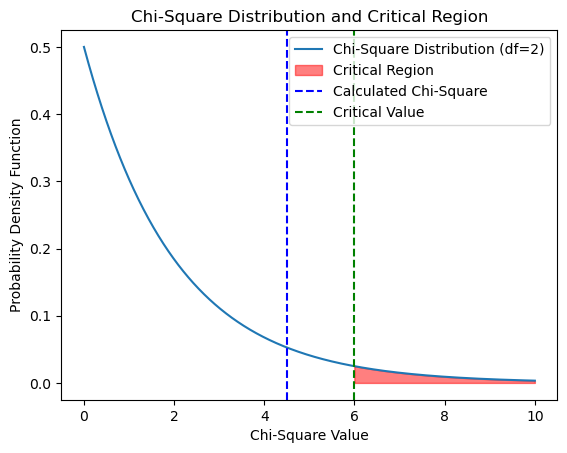

In [225]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as stats 

# Calculated chi-square from previous cell
calculated_chi_square = 4.505

# Degrees of freedom and significance level 
df = 2
alpha = 0.05
  
# Critical value from the Chi-Square distribution table 
critical_value = stats.chi2.ppf(1 - alpha, df) 
critical_value
  
# Generate values for the chi-square distribution 
x = np.linspace(0, 10, 1000) 
y = stats.chi2.pdf(x, df) 
  
plt.plot(x, y, label='Chi-Square Distribution (df=2)') 
plt.fill_between(x, y, where=(x > critical_value), color='red', alpha=0.5, label='Critical Region') 
plt.axvline(calculated_chi_square, color='blue', linestyle='dashed', label='Calculated Chi-Square') 
plt.axvline(critical_value, color='green', linestyle='dashed', label='Critical Value') 
plt.title('Chi-Square Distribution and Critical Region') 
plt.xlabel('Chi-Square Value') 
plt.ylabel('Probability Density Function') 
plt.legend() 
plt.show() 